## Basic Autodiff

In [1]:
using Plots, Zygote
gr() #set backend GR

Plots.GRBackend()

In [2]:
function g(x)
    if x>0
        return 3*x + x.*sin(x)
    else
        return -x
    end
end

g (generic function with 1 method)

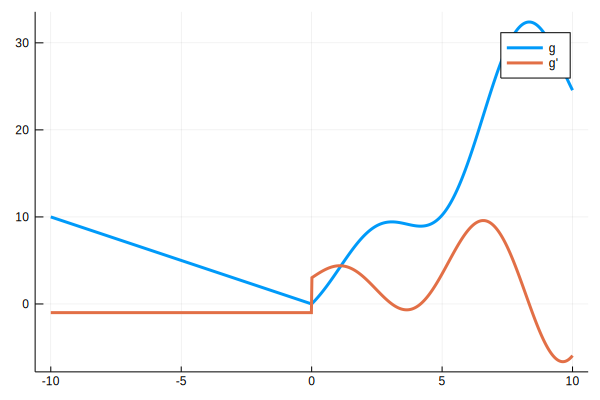

In [3]:
x = range(-10, stop=10, length=1000);
plot(x, [g.(x), g'.(x)],label=["g" "g'"],lw=3)
# plot!(x, g'.(x))

In [4]:
g'(5),g'(-5)

(3.459386652652993, -1)

## More complex stuff

In [16]:
using Zygote, LinearAlgebra

This example will showcase how we do a simple linear fit with Zygote, making
use of complex datastructures, a home-grown stochastic gradient descent
optimizer, and some good old-fashioned math.  We start with the problem
statement:  We wish to learn the mapping `f(X) -> Y`, where `X` is a matrix
of vector observations, `f()` is a linear mapping function and `Y` is a
vector of scalar observations.

Because we like complex objects, we will define our linear regression as the
following object:

In [17]:
mutable struct LinearRegression
    # These values will be implicitly learned
    weights::Matrix
    bias::Float64

    # These values will not be learned
    name::String
end
LinearRegression(nparams, name) = LinearRegression(randn(1, nparams), 0.0, name)

LinearRegression

Our linear prediction looks very familiar; 
$$w*X + b$$
(Yes it supports LaTeX)

In [18]:
predict(model::LinearRegression, X) = model.weights * X .+ model.bias;

Our "loss" that must be minimized is the l2 norm  between our current
prediction and our ground-truth Y

In [19]:
loss(model::LinearRegression, X, Y) = norm(predict(model, X) .- Y, 2);

Our "ground truth" values (that we will learn, to prove that this works)

In [20]:
weights_gt = [1.0, 2.7, 0.3, 1.2]';
bias_gt = 0.4;

Generate a dataset of many observations

In [21]:
X = randn(length(weights_gt), 10000)
Y = weights_gt * X .+ bias_gt

1×10000 Array{Float64,2}:
 2.33454  3.343  -0.412284  4.63289  1.25999  …  -6.6529  -2.7878  -2.94584

Add a little bit of noise to `X` so that we do not have an exact solution,
but must instead do a least-squares fit:

In [22]:
X .+= 0.001.*randn(size(X))

4×10000 Array{Float64,2}:
 -1.77138   -0.0826192   0.974305  …   0.579661  -2.43462   -0.418512
  1.38473    1.29912    -0.427958     -2.46921    0.357517  -0.505143
  1.12383    0.72225    -0.431498     -1.26103    1.12192   -1.15052 
 -0.305747  -0.586459   -0.421474     -0.48702   -1.71171   -1.01605 

Now we begin our "training loop", where we take examples from `X`,
calculate loss with respect to the corresponding entry in `Y`, find the
gradient upon our model, update the model, and continue.  Before we jump
in, let's look at what `Zygote.gradient()` gives us:

In [23]:
model = LinearRegression(size(X, 1), "Example");

Calculate gradient upon `model` for the first example in our training set

In [24]:
grads = Zygote.gradient(m -> loss(m, X[:,1], Y[1]), model)

(Base.RefValue{Any}((weights = [1.77138 -1.38473 -1.12383 0.305747], bias = -1.0, name = nothing)),)

The `grads` object is a Tuple containing one element per argument to
`gradient()`, so we take the first one to get the gradient upon `model`:

In [25]:
grads = grads[1]

Base.RefValue{Any}((weights = [1.77138 -1.38473 -1.12383 0.305747], bias = -1.0, name = nothing))

Because our LinearRegression object is mutable, the gradient holds a
reference to it, which we peel via `grads[]`:

In [26]:
grads = grads[]

(weights = [1.77138 -1.38473 -1.12383 0.305747], bias = -1.0, name = nothing)

We now get a `NamedTuple` so we can now do things like `grads.weight`. Let's
print it out, just to see what it looks like.  Note that while `weights` and
`bias` have gradients, `name` just naturally has a  gradient of `nothing`,
because it was not involved in the calculation of the output loss.

In [71]:
grads

(weights = [1.77138 -1.38473 -1.12383 0.305747], bias = -1.0, name = nothing)

Let's define an update rule that will allow us to modify the weights
of our model a tad bit according to the gradients

In [28]:
#! is julia inplace operation
function sgd_update!(model::LinearRegression, grads, η = 0.001)
    model.weights .-= η .* grads.weights
    model.bias -= η * grads.bias
end

sgd_update! (generic function with 2 methods)

In [103]:
# Now let's do that for each example in our training set:
function train(X, Y, model)
    println("Running train loop for $(size(X,2)) iterations")
    for idx in 1:size(X, 2)
        grads = Zygote.gradient(m -> loss(m, X[:, idx], Y[idx]), model)[1][]
        sgd_update!(model, grads)
    end
end

train (generic function with 1 method)

In [104]:
train(X, Y, model)

Running train loop for 10000 iterations


In [105]:
grads = Zygote.gradient(m -> loss(m, X, Y), model)[1][]

(weights = [6.59724 49.2859 -15.8176 40.2343], bias = -2.780177035253755, name = nothing)

In [106]:
# Now let's look at how well we've approximated the ground truth weights/bias:
println("Ground truth weights: $(weights_gt)")
println("Learned weights: $(round.(model.weights; digits=3))")
println("Ground truth bias: $(bias_gt)")
println("Learned bias: $(round(model.bias; digits=3))")

Ground truth weights: [1.0 2.7 0.3 1.2]
Learned weights: [1.0 2.702 0.299 1.202]
Ground truth bias: 0.4
Learned bias: 0.4


## Complex stuff